# Set up python imports & bootstrap

In [1]:
import sklearn, sklearn.datasets
import numpy as np

# Matplotlib, but with nicer defaults for Jupyter notebooks in 2021
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 200 


In [2]:
import torch
import torch.nn as nn

torch.manual_seed(31337) # for reproducible runs, manually set the PRNG seed

In [3]:
# Do we have GPU acceleration?
torch.cuda.is_available()

/home/jarvist/miniconda3/envs/MLBD-MRes/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


False

# Generate toy datasets

In [4]:
n_samples=200
np.random.seed(0) # reproducible runs for debugging

In [5]:
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

In [6]:
X,Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05) # interleaved semi-circles
X=X*2
Y=Y*2 # scale so it more nicely fits in our 5x5 window

In [7]:
# our 'easy', linearly separable classification
X,Y=sklearn.datasets.make_classification(n_features=2, n_redundant=0, n_samples=n_samples,
    n_informative=2, random_state=None, n_clusters_per_class=1)

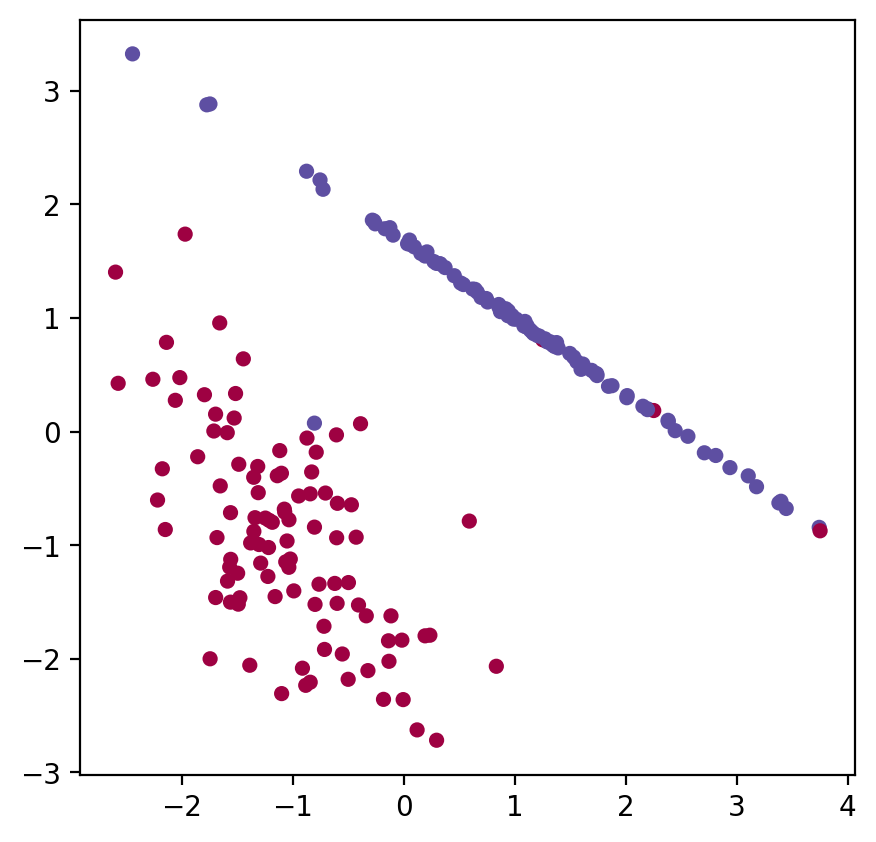

In [8]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

# Pytorch

> Welcome to the (wonderful) world of PyTorch! 
> 
> There are a lot of sharp edges, but PyTorch is still the least worst NN package.
> 
> Documentation: https://pytorch.org/docs/stable/nn.html

In [9]:
# Building a (linear) layer is supper simple! 
# Let's start by building the first half of the single neuron

# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

m=2 # the number of input legs
n=1 # the number of output legs

linearlayer = nn.Linear(m,n)

In [10]:
linearlayer(torch.Tensor([1,1]))

tensor([0.2600], grad_fn=<AddBackward0>)

In [11]:
rt=torch.randn(20, m) 
# get a load of random data of the correct size...

In [12]:
linearlayer(rt) # and pass through the linear layer

tensor([[-0.4197],
        [ 0.2589],
        [ 0.0741],
        [-0.3343],
        [ 0.2384],
        [ 0.1441],
        [-0.1722],
        [-0.8525],
        [-0.5155],
        [-0.9872],
        [-0.6629],
        [-0.2337],
        [ 0.2115],
        [ 0.6745],
        [-0.3154],
        [-0.1377],
        [ 0.1775],
        [-0.0575],
        [-0.6354],
        [ 0.0732]], grad_fn=<AddmmBackward0>)

In [13]:
# We can look at the weights and the biases of our model
#  The model is an object-orientated object, so has both data and functions
print("W", linearlayer.weight)
print("b", linearlayer.bias)

W Parameter containing:
tensor([[ 0.4160, -0.0271]], requires_grad=True)
b Parameter containing:
tensor([-0.1289], requires_grad=True)


# OK! Let's rebuild our binary classifier from the first session

> Now we have the full power of Pytorch to train it efficiently
>
> Changing the architecture of the network can be as simple as choosing a different named function

In [14]:
input_size=2 # two dimensional input
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers
model = nn.Sequential(nn.Linear(input_size, output_size),
                      nn.Sigmoid())
print(model)

# There is an alternative way to build arbitrary models in 
# PyTorch by constructing a Python class
# But this is considerably more complicated, involves a lot of 
# object-orientated boilerplate code, and isn't necessary for 
# simple architectures such as these.

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


In [15]:
# this should work! Just two arb. data points, should generate a scalar output
model(torch.tensor([0.0,0.0])) 

tensor([0.5906], grad_fn=<SigmoidBackward0>)

In [16]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions
lossfunction = nn.L1Loss()

#lossfunction = nn.MSELoss()

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

In [18]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

In [19]:
# training loop

losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=lossfunction(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

In [20]:
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

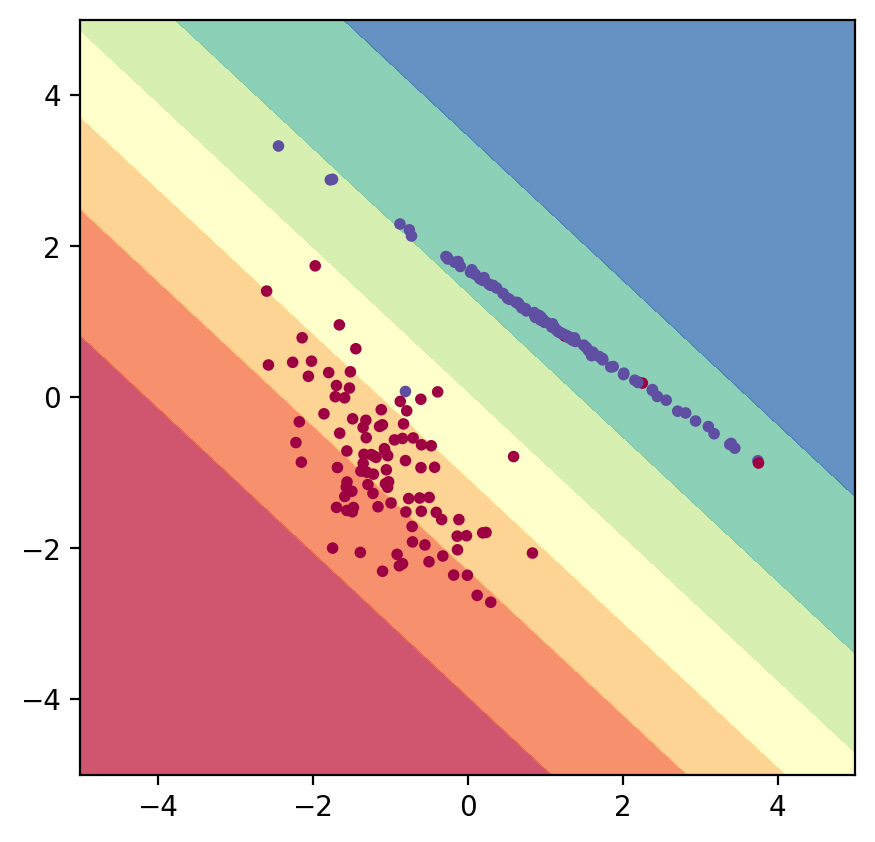

In [21]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

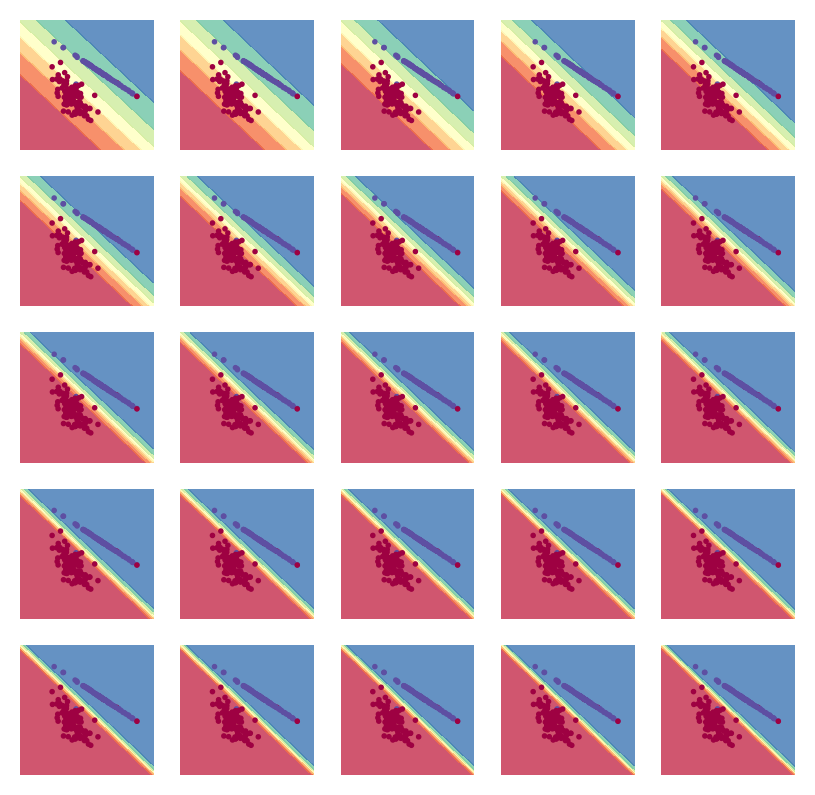

In [22]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


(0.0, 1.124428940564394)

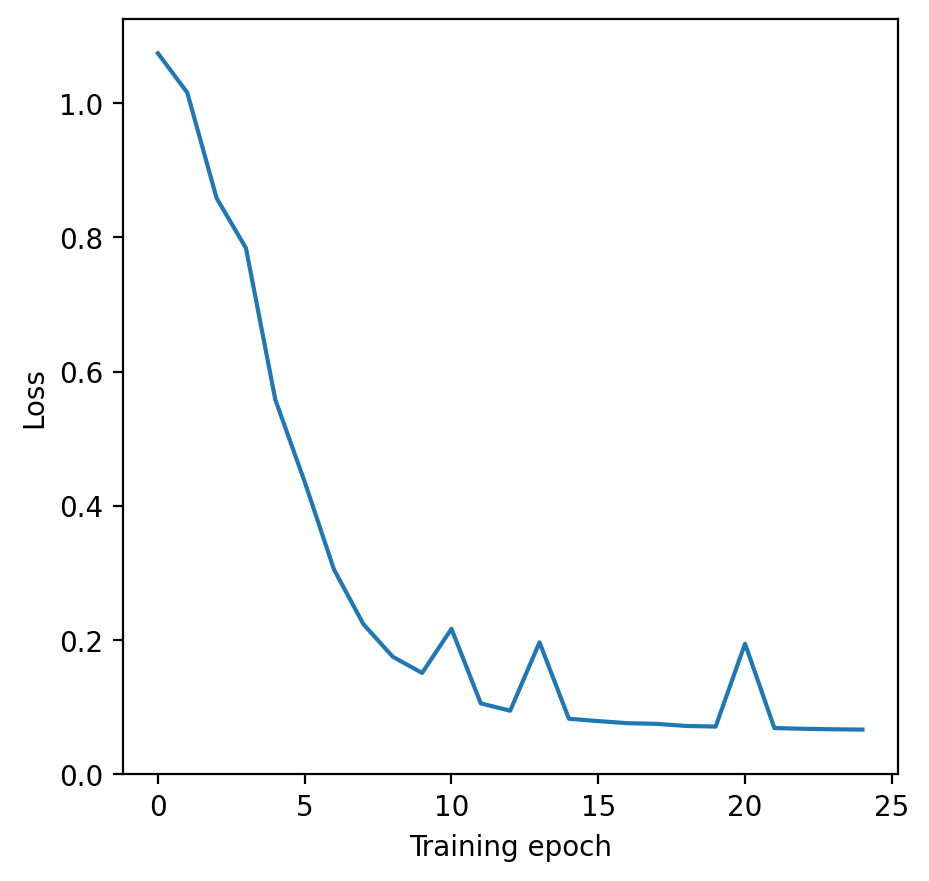

In [23]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

In [24]:
# Accuracy - what fraction of the train data go we correctly predict?
(Ytorch == torch.round(model(Xtorch))).float().mean()

tensor(0.9800)

In [25]:
# describe all parameters of model
for name,param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[6.6481, 6.7618]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.9631], requires_grad=True)


# Experiment with manually setting weights

0.weight Parameter containing:
tensor([[0., 1.]], requires_grad=True)
0.bias Parameter containing:
tensor([0.], requires_grad=True)
Accuracy tensor(0.8650)


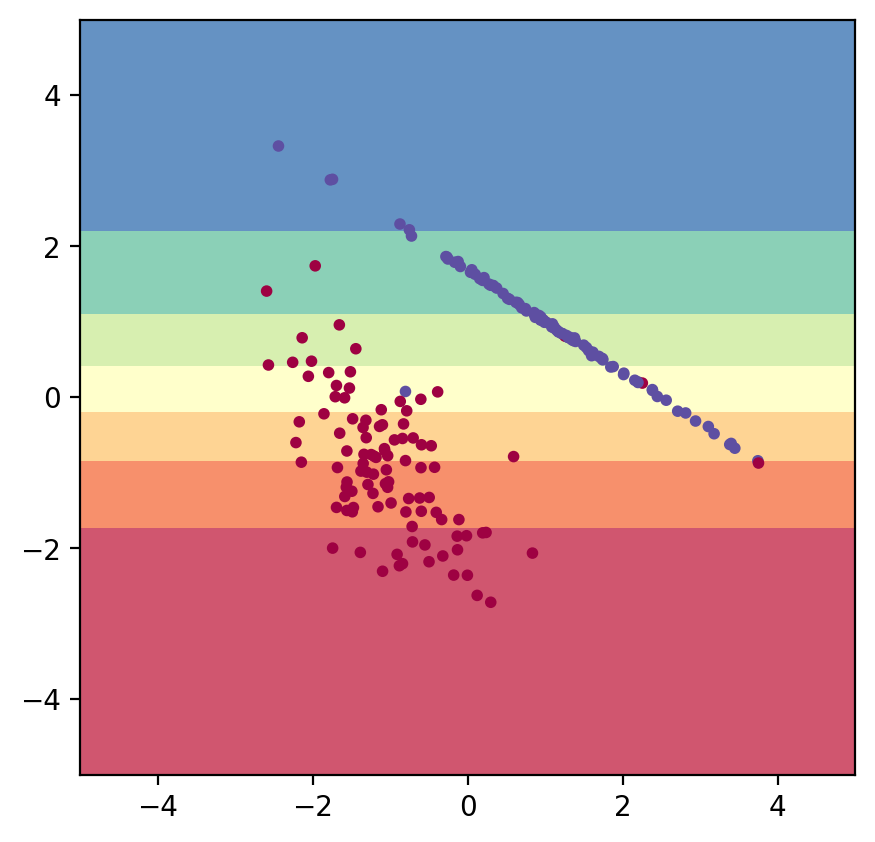

In [26]:
# And we can set the weights for the linear model manually
#  Try and do this to correctly describe the data!
with torch.no_grad():
    model[0].weight[0,0]=0
    model[0].weight[0,1]=1
    model[0].bias[0]=0
    
for name,param in model.named_parameters():
    print(name, param)
    
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

# Accuracy - what fraction of the train data go we correctly predict?
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

# Multilayer perceptron

From the first class work (and if not, experiment above!), a single neuron is capable of only linearly separating the input data. 

To go beyond this, and start to learn a representation of the data which reduces the dimensionality, you can make a multi-layer perceptron. 
This is where the term 'deep' learning comes from, once you have a deep network of many artificial neuron laers.

In [27]:
X,Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.05) # interleaved semi-circles
X=X*2
Y=Y*2 # scale so it more nicely fits in our 5x5 window

In [28]:
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

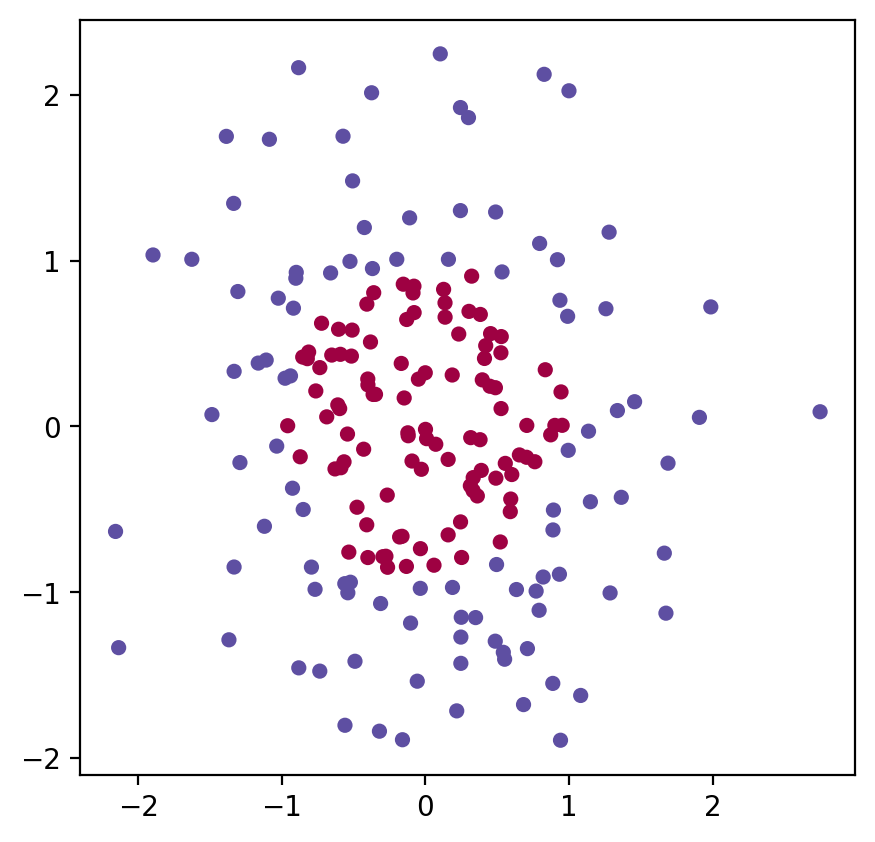

In [29]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

In [30]:
input_size=2 # two dimensional input
hidden_layer=30 # go wild!
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers
model = nn.Sequential(nn.Linear(input_size, hidden_layer, bias=True),
                      nn.ReLU(),
#                      nn.Linear(hidden_layer,hidden_layer, bias=True),
#                      nn.Sigmoid(),
                      nn.Linear(hidden_layer,output_size, bias=True),
                      nn.Sigmoid()
                     )
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): Sigmoid()
)


In [31]:
# this should work! Just two arb. data points, should generate a scalar output
model(torch.tensor([0.0,0.0])) 

tensor([0.5010], grad_fn=<SigmoidBackward0>)

In [32]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions
lossfunction = nn.L1Loss()

#lossfunction = nn.MSELoss()

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

In [34]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #lr = learning rate

In [36]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=16, shuffle=True)

In [37]:
# training loop

losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=lossfunction(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

In [38]:
# make a grid of predictions, for plotting the decision boundary
N=400
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

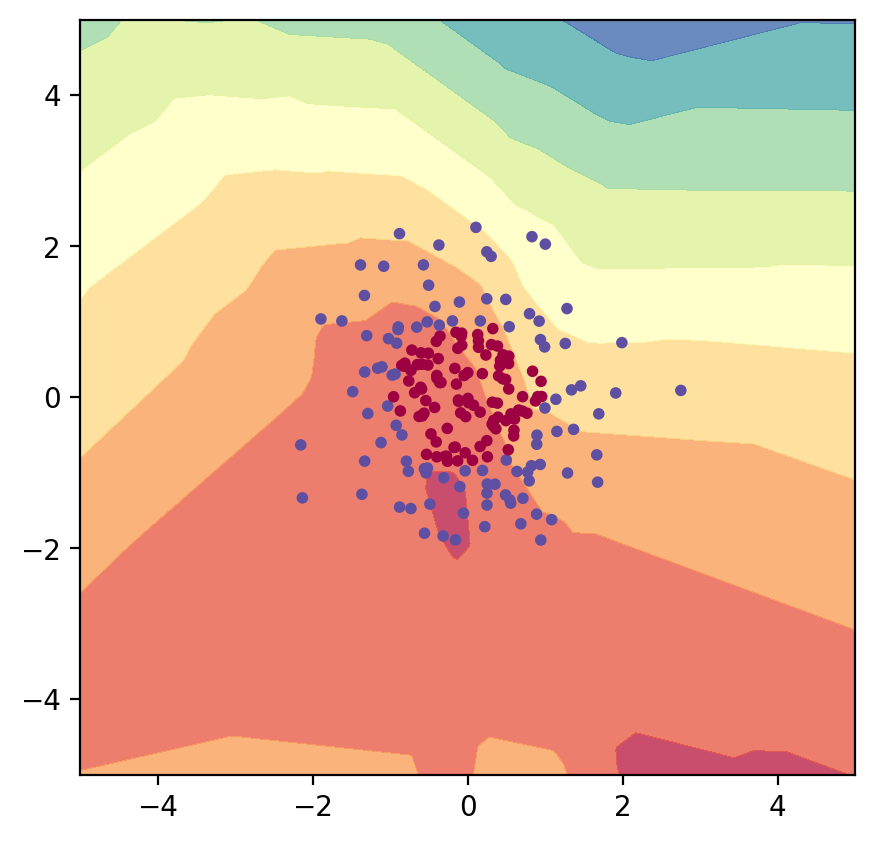

In [39]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

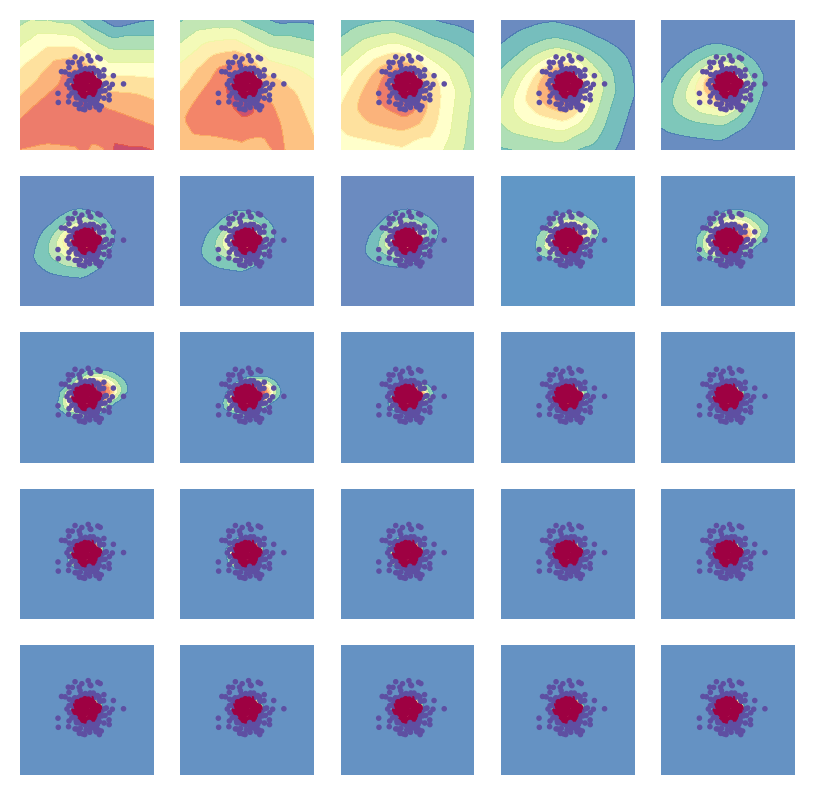

In [40]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


(0.0, 6.705628618597984)

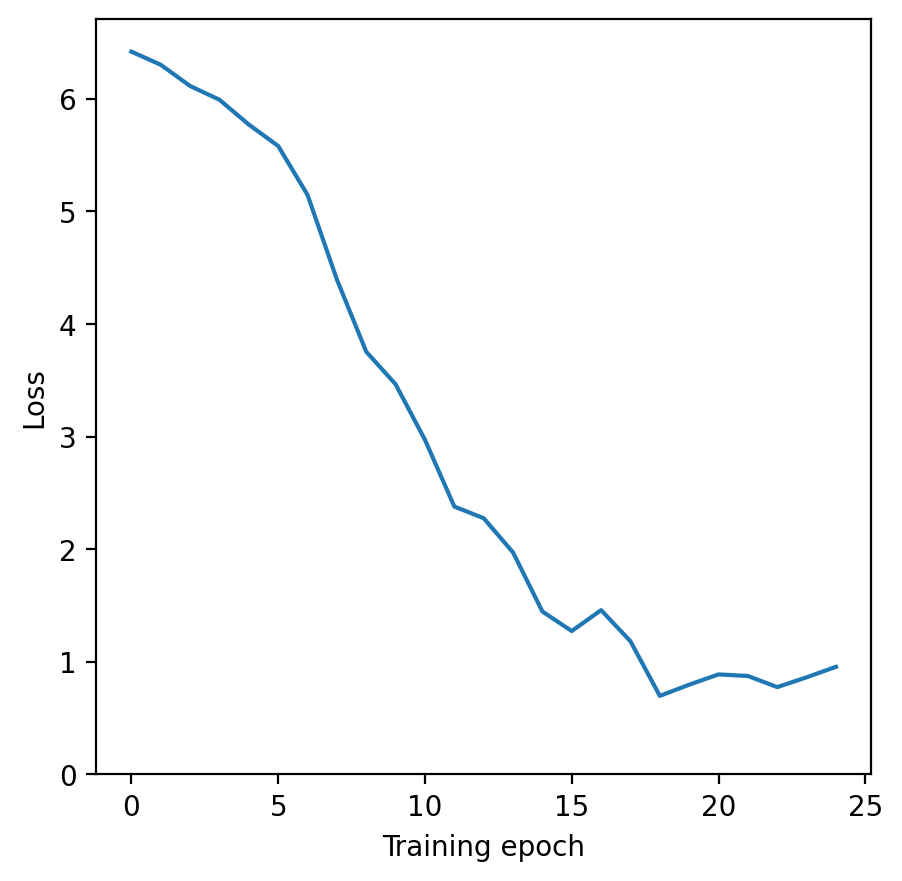

In [41]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

In [42]:
# Accuracy
(Ytorch == torch.round(model(Xtorch))).float().mean()

#predict = torch.round(model(Xtorch))

# Actually a ML model like this can be considered probabilistic, 
# but we are applying a cutoff probability of 0.5 to compare to 
# the binary data.
#predict
#p.mean()

tensor(0.9400)

In [43]:
# let's have a look at all our model parameters (including weights)
#  Note how much more complex we are than two weights!
model(Xtorch)

tensor([[5.4866e-08],
        [4.1440e-01],
        [6.9215e-13],
        [8.6809e-01],
        [3.8809e-06],
        [9.9988e-01],
        [8.3288e-06],
        [2.0878e-07],
        [7.9983e-01],
        [1.0000e+00],
        [2.1599e-03],
        [2.9351e-05],
        [3.2806e-04],
        [3.6418e-01],
        [3.7144e-04],
        [9.8420e-01],
        [9.9880e-01],
        [7.5254e-06],
        [1.0000e+00],
        [1.0000e+00],
        [5.2908e-14],
        [9.2304e-07],
        [1.0000e+00],
        [8.2857e-01],
        [7.2724e-14],
        [1.1115e-08],
        [8.4712e-01],
        [7.2900e-14],
        [1.9383e-07],
        [2.5644e-07],
        [1.0000e+00],
        [9.9882e-01],
        [9.9995e-01],
        [1.1717e-06],
        [1.0000e+00],
        [1.0000e+00],
        [1.6397e-10],
        [1.0000e+00],
        [1.0958e-13],
        [1.0000e+00],
        [5.2405e-01],
        [1.0000e+00],
        [9.9999e-01],
        [6.8521e-05],
        [1.0000e+00],
        [1

# Regression problem

> Live coded by Jarv in the last half hour of the practical session

In [44]:
# Define the data we are going to train with - analytic samples expressed on a linear grid
X=np.linspace(-4,4,50)
#Y=np.sin(X)
Y=np.exp(-X**2) # Gaussian

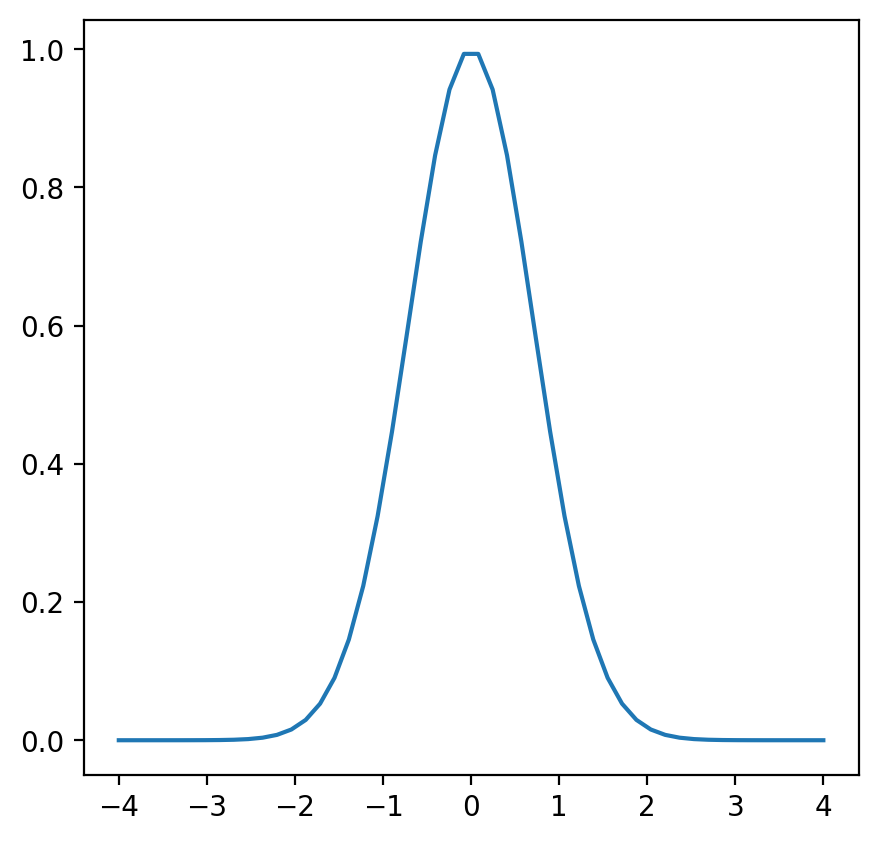

In [45]:
plt.plot(X,Y)

In [46]:
# Messing around to convert numpy arrays into PyTorch 'Tensors', and 'datasets' for use in the dataloader
Xtorch = torch.tensor(X).view(len(X),1).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

# The dataloader works with batches
# it's quite a sophisticated piece of software - it will also shuffle
# around data so that it is fed efficiently to the GPU
# As you are using batches => stochastic gradient descent
trainloader = torch.utils.data.DataLoader( D , batch_size=16, shuffle=True)

In [47]:
input_size=1 # two dimensional input
hidden_layer=25 # go wild!
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers
model = nn.Sequential(nn.Linear(input_size, hidden_layer, bias=True),
                      nn.ReLU(),
                      nn.Linear(hidden_layer,hidden_layer, bias=True),
                      nn.Sigmoid(),

                      nn.Linear(hidden_layer,output_size, bias=True)
                     # ,
                      #nn.Softmax()
                     )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=25, out_features=1, bias=True)
)


In [48]:
#lossfunction = nn.L1Loss()

lossfunction = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.2) #lr = learning rate; much larger for 1D problem

In [49]:
# training loop

losses=[]

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        optimizer.zero_grad()

        for Xtorch,Ytorch in trainloader: # pull a batch from the loader
            y=model(Xtorch) # forward pass through model
            loss=lossfunction(y, Ytorch) # supervised learning
            totalloss+=loss.detach()
            
            loss.backward() # calculate backward (gradient) pass
            optimizer.step() # use gradient info in optimise step
        losses.append(totalloss)

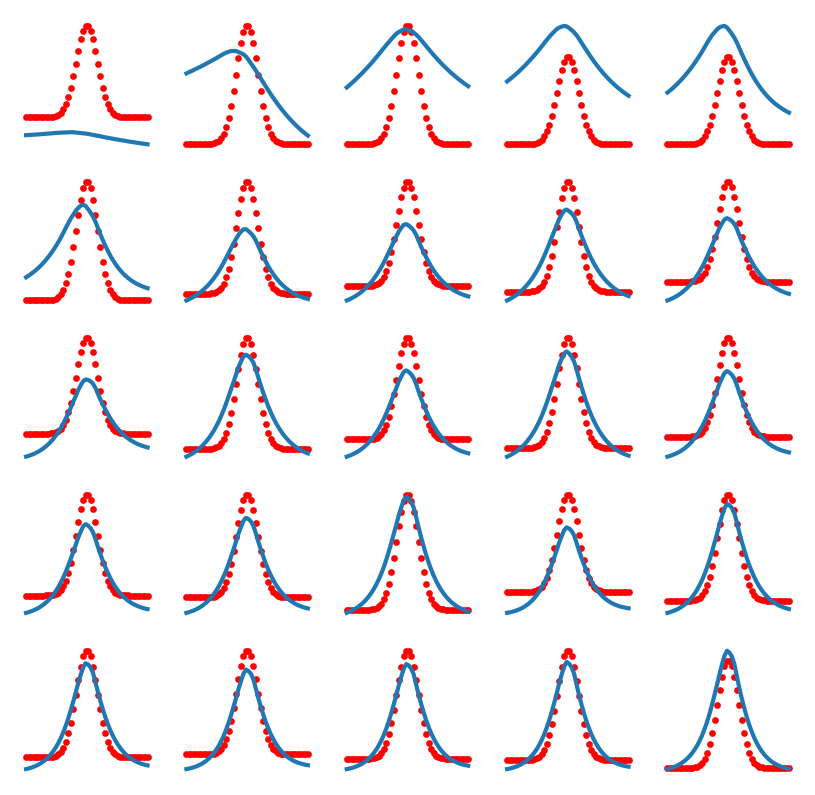

In [50]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    plt.scatter(X,Y, c='red', s=2)
    plt.plot(X,model(Xtorch).detach().numpy())    
    
    train(1)


(0.0, 2.1072501394723075)

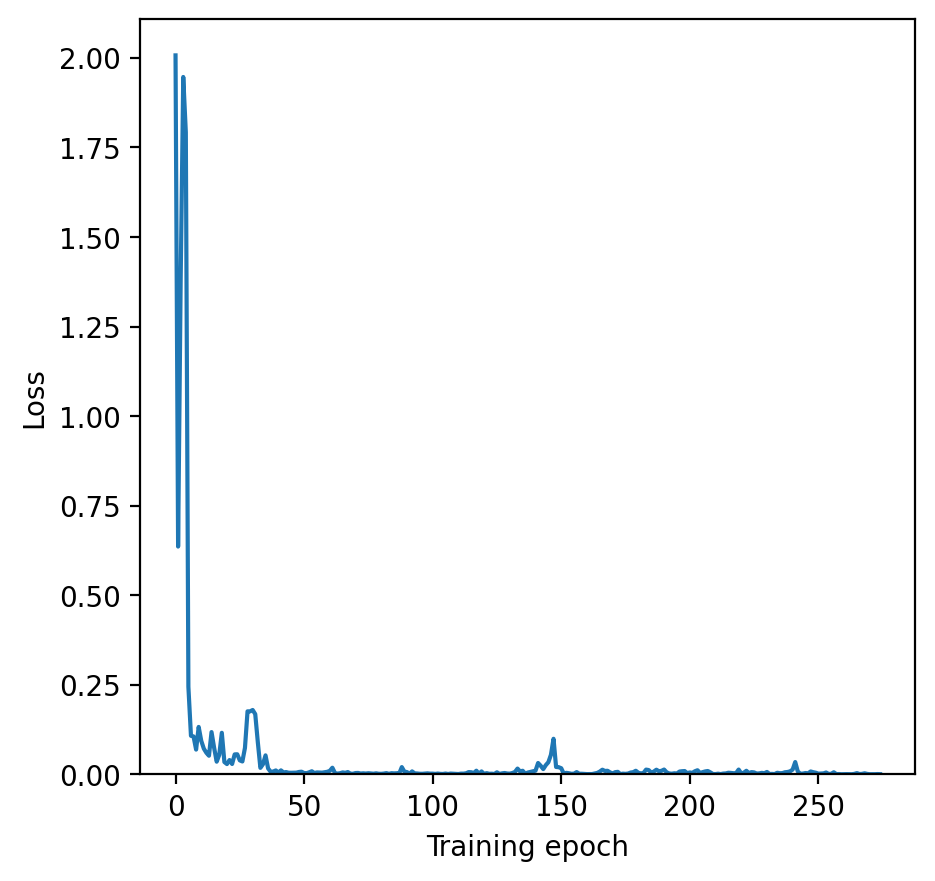

In [51]:
train(250)

plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

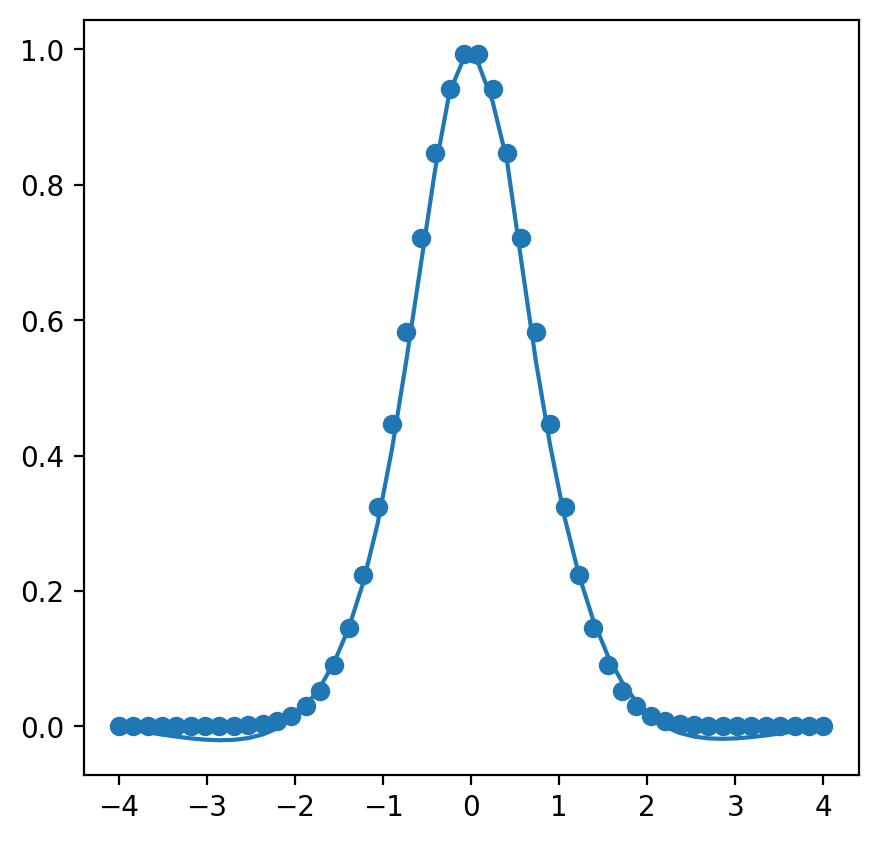

In [52]:
plt.scatter(X,Y)
plt.plot(X,model(Xtorch).detach().numpy())

> Beautiful!
>
> Isn't it amazing that a multilayer perceptron can fit an arbitrary function so well?
> 
> Well, OK. Maybe it's not so powerful - go back up to the function definition & try sin(x) for instance!